# LIBRARY AND CONFIGUATION

In [1]:
import os
os.chdir('../')
import numpy as np
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    
import pathlib
import tensorflow.compat.v2 as tf
import cv2
import argparse
import time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings
from helpers import load_label_map as label_map_util
from helpers import visualization_utils as viz_utils
from helpers import corner_utils, ocr_helpers

# LOAD SSD MOBILENET MODEL

In [11]:
tf.get_logger().setLevel('ERROR')
warnings.filterwarnings('ignore')


# PROVIDE PATH TO MODEL DIRECTORY
PATH_TO_MODEL_DIR = './models/discharge_record_area'
PATH_TO_SAVED_MODEL = PATH_TO_MODEL_DIR + "/saved_model"

# PROVIDE PATH TO LABEL MAP
PATH_TO_LABELS = './models/discharge_record_area/label_map.pbtxt'

# PROVIDE THE MINIMUM CONFIDENCE THRESHOLD
MIN_CONF_THRESH = 0.5

# NUM_CLASSES
NUM_CLASSES = 3

# LOAD SAVED MODEL AND BUILD DETECTION FUNCTION
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

# LOAD CATEGORY INDEX
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
num_classes = len(category_index)
list_class_init = set(list(category_index.keys()))

# CROP CORNER WITH OPENCV

In [30]:
%matplotlib inline


def crop_image(img):
    edges_image = corner_utils.edges_det(img)
    edges_image = cv2.morphologyEx(edges_image, cv2.MORPH_CLOSE, np.ones((5, 11)))
    page_contour =  corner_utils.find_page_contours(edges_image)
    page_contour =  corner_utils.four_corners_sort(page_contour)
    crop_image = corner_utils.persp_transform(img, page_contour)
    image = ocr_helpers.resize(crop_image)
    image_end = Image.fromarray(np.uint8(image)).convert('RGB')
    image_with_detections = image.copy()
    return image, image_end, image_with_detections

def detection(image):
    # DETECTIONS
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_expanded = np.expand_dims(image_rgb, axis=0)

    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]

    # input_tensor = np.expand_dims(image_np, 0)
    detections = detect_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                   for key, value in detections.items()}
    detections['num_detections'] = num_detections
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
    return detections
    
def split_field_discharge_record(detections, list_class_init, num_classes, crop_image):
    im_height, im_width = crop_image.shape[:2]
    boxes = [[im_height, im_width, 0, 0] for i in range(num_classes)]
    detection_classes = detections['detection_classes']
    detection_boxes  = detections['detection_boxes']
    detection_scores  = detections['detection_scores']
    ymin, xmin, ymax, xmax = (0,0,im_height, im_width)
    content = None
    hospital = None
    code = None
    check = {1: False, 2:False, 3: False}
    for i in range(len(detection_classes)):
        class_id = detection_classes[i]
        if detection_scores[i] < 0.5:
            continue
        if class_id == 1 and check[1] == False:
            ymin = int(detection_boxes[i][0]*im_height)
            xmin = int(detection_boxes[i][1]*im_width)
            ymax = int(detection_boxes[i][2]*im_height)
            xmax = int(detection_boxes[i][3]*im_width)
            content = (ymin,xmin,ymax,xmax)
            check[1] == True
        elif class_id == 2 and check[2] == False:
            ymin = int(detection_boxes[i][0]*im_height)
            xmin = int(detection_boxes[i][1]*im_width)
            ymax = int(detection_boxes[i][2]*im_height)
            xmax = int(detection_boxes[i][3]*im_width)
            hospital = (ymin,xmin,ymax,xmax)
            check[2] == True
        elif class_id == 3 and check[2] == False:
            ymin = int(detection_boxes[i][0]*im_height)
            xmin = int(detection_boxes[i][1]*im_width)
            ymax = int(detection_boxes[i][2]*im_height)
            xmax = int(detection_boxes[i][3]*im_width)
            code = (ymin,xmin,ymax,xmax)
            check[3] == True
        if check[1] == True and check[2] == True and check[3] == True:
            break
    content = crop_image[content[0]:content[2], content[1]:content[3]]
    hospital = crop_image[hospital[0]:hospital[2], hospital[1]:hospital[3]]
    return content

def crop_and_recog(box):
    end = image[box[0]:box[2], box[1]:box[3]]
    return end

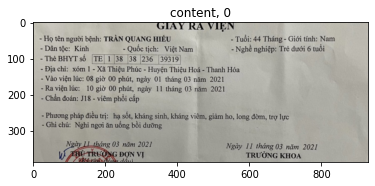

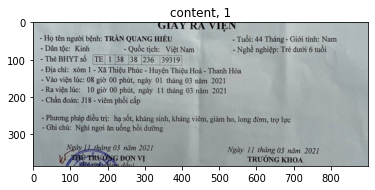

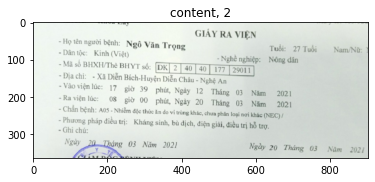

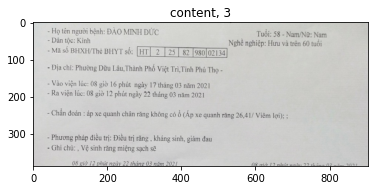

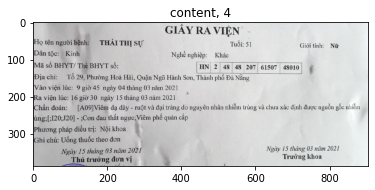

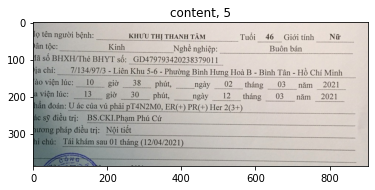

In [34]:
for i in range(6):
    img = ocr_helpers.read_image_from_dir(r'./test_data/discharge_record/{}.jpg'.format(str(i)))
    img = np.asarray(img)
    image, image_end, image_with_detections = crop_image(img)
    detections = detection(image)
    content = split_field_discharge_record(detections, list_class_init, num_classes, image)
    ocr_helpers.implt(content, None, category_index[1]['name'] + ', ' + str(i))